<a href="https://colab.research.google.com/github/faizaazzahra/Artificial_Intelligence/blob/main/UAS_AI_Faiza_Putri_Azzahra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Faiza Putri Azzahra

NIM : 20220801290

UAS Artificial Intelligence

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from google.colab import files

Langkah 1: Preprocessing Data

*   Kumpulkan dataset (menaruh file kaggle yang telah di unduh)

In [ ]:
# === 1. Upload Dataset ===
uploaded = files.upload()
filename = list(uploaded.keys())[0]  # Ambil nama file yang di-upload
df = pd.read_csv(filename)

Saving netflix_titles.csv to netflix_titles.csv


*   Bersihkan data (hilangkan missing value, outlier)

In [ ]:
# === 2. Data Cleaning ===
df = df.copy()
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')
df['date_added'] = df['date_added'].fillna(df['date_added'].mode()[0])
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])
df['duration'] = df['duration'].fillna(df['duration'].mode()[0])

# Mengambil angka dari kolom duration
df['duration_numeric'] = df['duration'].astype(str).str.extract('(\d+)').astype(float)
df['duration_type'] = np.where(df['duration'].astype(str).str.contains('Season'), 'Seasons', 'Minutes')

Langkah 2: Clustering

Saya akan menggunakan K-Means Clustering untuk mengelompokkan data berdasarkan yang relevan. Saya akan menggunakan fitur numerik yang relevan, seperti:
*   release_year (tahun rilis)
*   duration_numeric (durasi dalam menit atau jumlah musim)

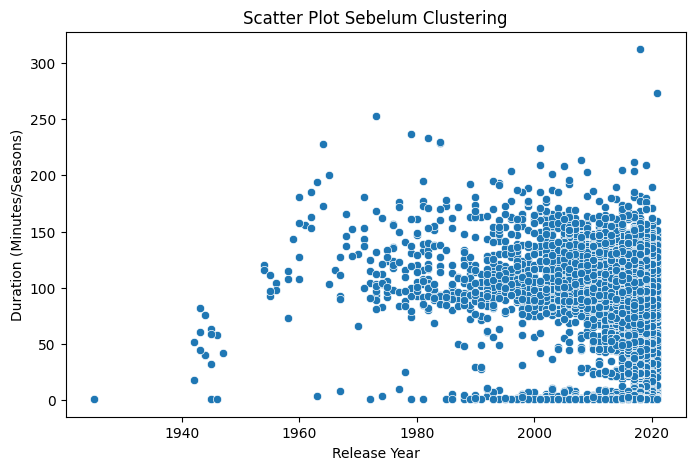

In [ ]:
# === 3. Clustering dengan K-Means ===
features = df[['release_year', 'duration_numeric']].dropna()

# Visualisasi sebelum clustering
plt.figure(figsize=(8,5))
sns.scatterplot(x=features['release_year'], y=features['duration_numeric'])
plt.xlabel("Release Year")
plt.ylabel("Duration (Minutes/Seasons)")
plt.title("Scatter Plot Sebelum Clustering")
plt.show()

*   Menentukkan jumlah klaster (K) dan menjalankan K-Means Clustering.

Saya menggunakan metode Elbow Method untuk mencari jumlah klaster yang optimal dan langsung menjalankan klaster dengan menggunakan K-Means Clustering.

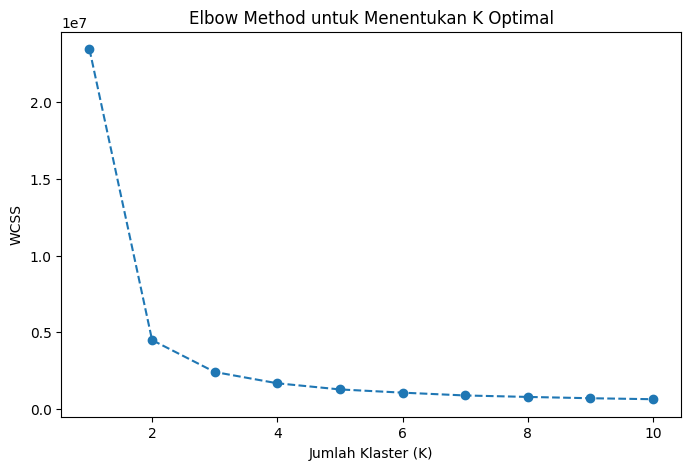

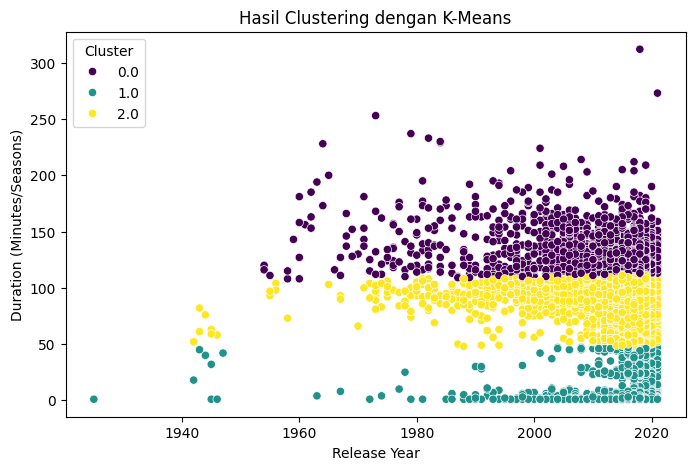

In [ ]:
# Elbow Method untuk Menentukan K Optimal
wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel("Jumlah Klaster (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method untuk Menentukan K Optimal")
plt.show()

# Jalankan K-Means dengan K = 3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df.loc[features.index, 'cluster'] = kmeans.fit_predict(features)

# Visualisasi hasil clustering
plt.figure(figsize=(8,5))
sns.scatterplot(x=features['release_year'], y=features['duration_numeric'], hue=df.loc[features.index, 'cluster'], palette='viridis')
plt.xlabel("Release Year")
plt.ylabel("Duration (Minutes/Seasons)")
plt.title("Hasil Clustering dengan K-Means")
plt.legend(title="Cluster")
plt.show()

Langkah 3: Menggabungkan dengan Machine Learning.

Karena ingin memprediksi klaster (kategori), saya menggunakan model klasifikasi yaitu Random Forest Classifier sebagai model awal. Saya akan memprediksi klaster berdasarkan fitur-fitur seperti:

*   duration_numeric
*   rating (dikodekan menjadi numerik)
*   type (movie/tv show, dikodekan menjadi numerik)

In [ ]:
# === 4. Machine Learning (Klasifikasi) ===
le_type = LabelEncoder()
df['type_encoded'] = le_type.fit_transform(df['type'])
le_rating = LabelEncoder()
df['rating_encoded'] = le_rating.fit_transform(df['rating'])

# Pilih fitur untuk training
X = df[['release_year', 'duration_numeric', 'type_encoded', 'rating_encoded']].dropna()
y = df.loc[X.index, 'cluster']

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Latih model Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluasi model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       353
         1.0       1.00      1.00      1.00       594
         2.0       1.00      1.00      1.00       815

    accuracy                           1.00      1762
   macro avg       1.00      1.00      1.00      1762
weighted avg       1.00      1.00      1.00      1762



Hasil prediksi klaster menggunakan model Random Forest menujukkkan akurasi 100%, yang di mana model dapat memprediksi klaster dengan sangat baik.

Langkah 4: Evaluasi dan Pengoptimalan

Untuk memastikan lebih lanjut evaluasi kerja dari model Random Forest, saya menggunakan cross-validation.  

In [ ]:
# === 5. Cross Validation ===
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Scores: [0.99943246 0.99943246 1.         0.99886428 0.99772856]
Mean Accuracy: 1.00


Hasil dari cross-validation menunjukkan rata-rata akurasi masih tinggi dan stabil, yang mengartikan bahwa model berfungsi dengan baik dan tidak hanya menghafal data training.

*   Melakukan pengomptimalan hyperparameter.

Dengan dilakukannya Grid Search berfungsi untuk mencari kombinasi hyperparameter terbaik.

In [ ]:
# === 6. Hyperparameter Tuning ===
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


Dari pengoptimalan hyperparameter diperoleh hasil yang tidak jauh berbeda dari model awal, dapat disimpulkan model sudah cukup optimal.

*   Membandingkan hasil dengan model tanpa clustering.

In [ ]:
# Memilih fitur tanpa menggunakan cluster
X_no_cluster = df[['release_year', 'duration_numeric', 'type_encoded', 'rating_encoded']]  # Tanpa 'cluster'
y_no_cluster = df['cluster']  # Masih menggunakan hasil clustering sebagai label

# Membagi data menjadi training dan testing (80:20)
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no_cluster, y_no_cluster, test_size=0.2, random_state=42)

# Melatih model Random Forest
model_no_cluster = RandomForestClassifier(n_estimators=100, random_state=42)
model_no_cluster.fit(X_train_no, y_train_no)

# Prediksi pada data uji
y_pred_no = model_no_cluster.predict(X_test_no)

# Evaluasi akurasi model
accuracy_no = accuracy_score(y_test_no, y_pred_no)

# Menampilkan hasil akurasi
print(f"Accuracy without clustering: {accuracy_no:.2f}")

Accuracy without clustering: 1.00


Hasil menunjukkan bahwa akurasi dengan dan tanpa clustering tetap 100%.

Kesimpulan:

*   Akurasi model dengan dan tanpa clustering sama-sama 100%. Ini menunjukkan bahwa fitur release_year, duration_numeric, type_encoded, dan rating_encoded sudah cukup kuat untuk membedakan kategori tanpa perlu menggunakan hasil klaster sebagai fitur tambahan.
*   Clustering tidak memberikan peningkatan akurasi pada model klasifikasi. Namun, clustering tetap berguna untuk eksplorasi data dan memahami pola distribusi berdasarkan fitur yang digunakan.

